# FASTCOVNET: COVID CLASSIFICATION WITH CHEST RADIOGRAPHY AND TABULAR DATA

### Load required modules

In [1]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

from monai.config import print_config
from monai.transforms import \
    Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom, NormalizeIntensity, RepeatChannel
from monai.networks.nets import densenet121
from monai.metrics import compute_roc_auc
from sklearn.metrics import roc_auc_score

import pandas as pd
import random

import matplotlib.pyplot as plt
import datetime

import torchvision.models as models
import torch.nn as nn

pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_columns', None)

np.random.seed(1)
print_config()


MONAI version: 0.3.0
Python version: 3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56)  [GCC 7.3.0]
OS version: Linux (5.4.0-40-generic)
Numpy version: 1.19.1
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.16.2
Pillow version: 7.2.0
Tensorboard version: 2.2.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.7.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.48.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Read data and set vars

In [2]:
# Vars
working_directory = '/mnt/datasets/fastcovnet/'
columnToPredict = 'Case_type'
resolution = '224'
path_saved_model = os.path.expanduser("~")+'/best_metric_'+columnToPredict+'_'+resolution+'.pth'

In [3]:
# Image part read
image_data = pd.read_csv(os.path.join(working_directory,'cohort_gold_20201116.csv'),"|")

In [4]:
# Tabular part read
tab_data = pd.read_csv(os.path.join("/home/bvelasco/fastcovnet",'gold_tabular.csv'),"|")

In [5]:
# Remove rows with same patient, same study date
patient_dup = image_data[image_data.PatientId.duplicated(keep=False)]
patient_date_dup = patient_dup[patient_dup.StudyDateTime.duplicated()]

In [6]:
# Drop duplicate patients from tabular data and merge. then drop NAs
tab_data.drop_duplicates(['PatientId'], inplace=True)
#image_data.drop_duplicates(['PatientId'], inplace=True)
data = pd.merge(tab_data, image_data, on='PatientId', how='left')
data = data[~data.StudyDateTime.isna()]

In [7]:
# NULL removal of predicted variable
data = data[data[columnToPredict].isna()==False]

# Select multimodal columns and impute values
tab_cols = ['Sex', 'Age', 'TROPO', 'HB', 'HEMATOCRITO', 'SatO2'] 
data[tab_cols] = data[tab_cols].fillna(data[tab_cols].mean()) # no nas in categorical vars

# Convert columnToPredict to string, just in case they're numbers, so we don't have any errors.
data[columnToPredict] = data[columnToPredict].astype(str)

In [8]:
# Classes to predict
class_names = sorted(data[columnToPredict].unique())
num_class = len(class_names)
data[columnToPredict].value_counts()

Case       754
Control    284
Name: Case_type, dtype: int64

In [9]:
# Create list with directory of images and their labels
data.reset_index(inplace=True, drop=True)
data[columnToPredict] = pd.Categorical(data[columnToPredict])
data["to_predict"] = data[columnToPredict].cat.codes
dict(enumerate(data[columnToPredict].cat.categories))

image_file_list = data.path_jpg.tolist()
image_label_list = data.to_predict.tolist()

num_total = len(image_label_list) 

In [10]:
# Balance classes - not used here
num_conts = data[data[columnToPredict]=='Control'].shape[0]
data_controls = data[data[columnToPredict]=='Control']
data_casos = data[data[columnToPredict]=='Case'].sample(num_conts)
data = pd.concat([data_casos, data_controls])
num_total = num_conts*2
data[columnToPredict].value_counts()

Control    284
Case       284
Name: Case_type, dtype: int64

In [11]:
# Select from image_file_list and label_file_list the images that are actually in data after balancing
mapping = map(image_file_list.__getitem__, data.index.to_numpy())
image_file_list_2 = list(mapping)
mapping = map(image_label_list.__getitem__, data.index.to_numpy())
image_label_list_2 = list(mapping)

## Prepare training, validation and test data lists
Randomly select 10% of the dataset as validation and 10% as test.

In [12]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

# Keep record of which split which image goes to (test, train, val). Later append to "data" csv
split = []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list_2[i])
        valY.append(image_label_list_2[i])
        split.append('val')
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list_2[i])
        testY.append(image_label_list_2[i])
        split.append('test')
    else:
        trainX.append(image_file_list_2[i])
        trainY.append(image_label_list_2[i])
        split.append('train')

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 452 Validation count = 71 Test count = 45


In [13]:
# Add the info of which split belongs to each datapoint to the table
path_split = pd.DataFrame({
    'path_jpg': image_file_list_2,
    'Split': split
})
data = pd.merge(data, path_split, on='path_jpg', how='left')

In [14]:
data[data['Split']=='train']['Case_type'].value_counts()

Control    230
Case       222
Name: Case_type, dtype: int64

In [15]:
data[data['Split']=='test']['Case_type'].value_counts()

Case       28
Control    17
Name: Case_type, dtype: int64

In [16]:
data[data['Split']=='val']['Case_type'].value_counts()

Control    37
Case       34
Name: Case_type, dtype: int64

## Define transforms, Dataset, Dataloader

In [17]:
train_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    RepeatChannel(3),
    ScaleIntensity(),
    RandRotate(range_x=90, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

val_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RepeatChannel(3),
    ToTensor()
])

In [18]:
# Columns of interest of the tabular data
class ChestCovNetDataset(Dataset):

    def __init__(self, image_files, labels, tabular_data, tab_cols, transforms):
        self.image_files = image_files
        self.labels = labels
        self.tabular_data = tabular_data
        self.tabular_cols = tab_cols
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        # Get tabular data of each image (in this case sex and age)
        image = self.transforms(self.image_files[index])
        tab_vector = self.tabular_data.iloc[index][self.tabular_cols]
        tab_vector = torch.tensor(tab_vector).float()     
        return (tab_vector, image), self.labels[index]

train_ds = ChestCovNetDataset(trainX, trainY, data, tab_cols, train_transforms)
train_loader = DataLoader(train_ds, batch_size=15, shuffle=True, num_workers=10)

val_ds = ChestCovNetDataset(valX, valY, data, tab_cols, val_transforms)
val_loader = DataLoader(val_ds, batch_size=15, num_workers=10)

test_ds = ChestCovNetDataset(testX, testY, data, tab_cols, val_transforms)
test_loader = DataLoader(test_ds, batch_size=15, num_workers=10)

In [19]:
# Inherit from Function
class LinearFunction(torch.autograd.Function): # Not required

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, input, weight, bias=None):
        ctx.save_for_backward(input, weight, bias)
        output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None

        # These needs_input_grad checks are optional and there only to
        # improve efficiency. If you want to make your code simpler, you can
        # skip them. Returning gradients for inputs that don't require it is
        # not an error.
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)

        return grad_input, grad_weight, grad_bias

In [20]:
class Linear_combinative(nn.Module): # Not used
    def __init__(self, img_in_features, tab_in_features, output_features, bias=True):
        super(Linear_combinative, self).__init__()
        self.img_in_features = img_in_features
        self.tab_in_features = tab_in_features
        self.output_features = output_features

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        self.weight1 = nn.Parameter(torch.Tensor(output_features, img_in_features))
        self.weight2 = nn.Parameter(torch.Tensor(output_features, tab_in_features))
        if bias:
            self.bias1 = nn.Parameter(torch.Tensor(output_features))
            self.bias2 = nn.Parameter(torch.Tensor(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # Not a very smart way to initialize weights
        self.weight1.data.uniform_(-0.1, 0.1)
        self.weight2.data.uniform_(-0.1, 0.1)
        
        
        if self.bias1 is not None:
            self.bias1.data.uniform_(-0.1, 0.1)
            self.bias2.data.uniform_(-0.1, 0.1)

    #def forward(self, input):
    #    # See the autograd section for explanation of what happens here.
    #    img_part = LinearFunction.apply(input[0], self.weight1, self.bias1)
    #    tab_part = LinearFunction.apply(input[1], self.weight2, self.bias2)
    #    return img_part + tab_part
    
    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        img_part = LinearFunction.apply(input[0], self.weight1, self.bias1)
        tab_part = LinearFunction.apply(input[1], self.weight2, self.bias2)
        concatenated_data = torch.cat(img_part, tab_part)
        return concatenated_data

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'image_input_features={}, tabular_input_features={}, output_features={}, bias={}'.format(
            self.img_in_features, self.tab_in_features, self.output_features, self.bias1 is not None
        )
    

# Define our custom network, and the modules that will conform it

In [21]:
# Define our own network class, MultiModalNet
class MultiModalNet(nn.Module):
    
    def __init__(self, image_model, tab_model, classifier):
        super(MultiModalNet, self).__init__()
        #self()._init_()
        self.image_model = image_model
        self.tab_model = tab_model
        self.classifier = classifier
               
            
    def forward(self, x):        
        # Separate image part from tabular part
        t = x[0]
        im = x[1]
        
        # Feed image part
        x = self.image_model(im)
        x = torch.flatten(x, 1)
        
        # Feed tabular part
        t = self.tab_model(t)
        
        # Concatenate image output part with tabular data and feed to Linear combinative layer
        z = torch.cat((x, t), 1)
        y = self.classifier(z)
        return y
        

## Image part

In [22]:
# Load image trained model
device = torch.device("cuda:0")
image_model = models.googlenet(pretrained=True)
image_model.fc = nn.Sequential(
    nn.Linear(in_features = 1024, out_features = 1, bias = True),
    nn.Sigmoid()
    ) # must be in same shape as the trained one
checkpoint = torch.load('best_metric_GoogLeNet_224.pth') # load state
image_model.load_state_dict(checkpoint["model"])

# Freeze model and adapt last layer
for param in image_model.parameters(): 
    param.requires_grad = False
image_feats = 1024
image_model.fc = image_model.fc = nn.Sequential(
    nn.Linear(in_features = 1024, out_features = image_feats, bias = True),
    nn.Sigmoid()
    ) # Adapt last layer
image_model.fc.requires_grad=True
image_model = image_model.to(device)

In [23]:
#image_model

## Tabular part

In [24]:
# Create tabular part model (fully connected, 1 hidden layer)
tab_in = len(tab_cols)
tab_hidden = 200
tab_feats = 100
tab_model = nn.Sequential(
    nn.Linear(tab_in, tab_hidden),
    nn.ReLU(),
    nn.Linear(tab_hidden, tab_feats))
tab_model.to(device)

Sequential(
  (0): Linear(in_features=6, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=100, bias=True)
)

In [25]:
# Create last part, classifier
image_feats = 1024
classifier = nn.Sequential(
    nn.Linear(in_features = tab_feats+image_feats, out_features = 1, bias = True),
    nn.Sigmoid()
    )
classifier.to(device)

Sequential(
  (0): Linear(in_features=1124, out_features=1, bias=True)
  (1): Sigmoid()
)

In [26]:
multi_model = MultiModalNet(image_model=image_model, tab_model=tab_model, classifier=classifier)
multi_model.to(device)
print('done')

done


## Define optimizer and loss

In [27]:
## Model name and path to save model
model_name = multi_model.__class__.__name__
path_saved_model = 'multi_model.pth'

## Loss and optimizer
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(multi_model.parameters(), 1e-5)

epoch_num = 100
val_interval = 1

## Model training

In [28]:
if 'best_metric' not in vars():
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    val_loss_values = list()
    metric_values = list()
    checkpoint = {
    }
    
early_stop = False
patience_tol = 1e-2

# Measure time
start = datetime.datetime.now()

for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    multi_model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs = [batch_data[0][0].to(device), batch_data[0][1].to(device)]
        labels = batch_data[1].float().to(device)
        optimizer.zero_grad()
        outputs = multi_model(inputs)
        outputs = outputs.view(-1)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        #print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        multi_model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            #valid_loss=0
            
            for val_data in val_loader:
                val_images = [val_data[0][0].to(device), val_data[0][1].to(device)]
                val_labels = val_data[1].float().to(device)
                y_pred = torch.cat([y_pred, multi_model(val_images).view(-1)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
                
            auc_metric = roc_auc_score(y.cpu(), y_pred.cpu())
            metric_values.append(auc_metric)
            
            score = y_pred>0.5
            acc_value = torch.eq(score, y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            
            valid_loss = loss_function(y_pred, y)
            print(valid_loss)
            val_loss_values.append(valid_loss)
            
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                checkpoint['model'] = multi_model.state_dict()
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
            
            #if epoch>4:
            #    if val_loss_values[epoch]-val_loss_values[epoch-4] < patience_tol:
            #        best_metric = auc_metric
            #        best_metric_epoch = epoch + 1
            #        checkpoint['model'] = model.state_dict()
            #        print('saved new best metric model')
            #        print(f"train completed, early stop, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
            #        early_stop = True
            #        break
                    
                    
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

time = datetime.datetime.now() - start



----------
epoch 1/100
epoch 1 average loss: 0.7887
tensor(0.7805, device='cuda:0')
saved new best metric model
current epoch: 1 current AUC: 0.3251 current accuracy: 0.3521 best AUC: 0.3251 at epoch: 1
----------
epoch 2/100
epoch 2 average loss: 0.7613
tensor(0.7571, device='cuda:0')
saved new best metric model
current epoch: 2 current AUC: 0.3378 current accuracy: 0.3803 best AUC: 0.3378 at epoch: 2
----------
epoch 3/100
epoch 3 average loss: 0.7460
tensor(0.7431, device='cuda:0')
saved new best metric model
current epoch: 3 current AUC: 0.3498 current accuracy: 0.3944 best AUC: 0.3498 at epoch: 3
----------
epoch 4/100
epoch 4 average loss: 0.7263
tensor(0.7279, device='cuda:0')
saved new best metric model
current epoch: 4 current AUC: 0.3831 current accuracy: 0.4507 best AUC: 0.3831 at epoch: 4
----------
epoch 5/100
epoch 5 average loss: 0.7124
tensor(0.7174, device='cuda:0')
saved new best metric model
current epoch: 5 current AUC: 0.4261 current accuracy: 0.4930 best AUC: 0.42

## Save the model


In [29]:
# Let's save model and current status
checkpoint['optimizer'] = optimizer.state_dict()
checkpoint['epoch_loss_values'] = epoch_loss_values
checkpoint['metric_values'] = metric_values

torch.save(checkpoint, 'multimodal.pth')

## Load the model

In [30]:
# Let's load the best model and our current training state
#checkpoint = torch.load(path_saved_model)
checkpoint = torch.load('multimodal.pth')


multi_model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

epoch_loss_values = checkpoint['epoch_loss_values']
metric_values = checkpoint['metric_values']

## Plot the loss and metric

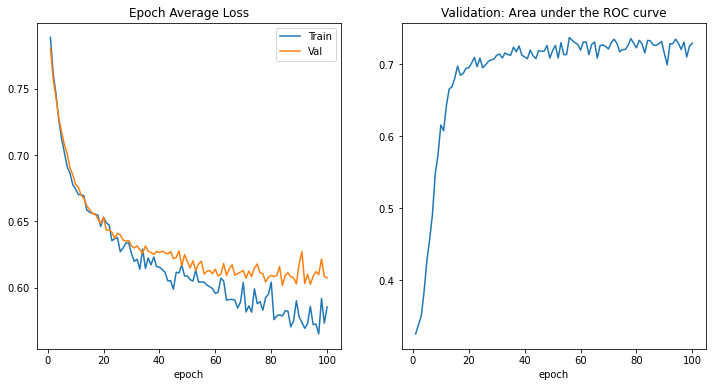

In [31]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.plot(x, y)
x = [i + 1 for i in range(len(val_loss_values))]
y = val_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.legend(['Train', 'Val'])

plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.savefig("/home/bvelasco/Results/Multi/Exp4.jpg")
plt.show()

## Evaluate the model on test dataset
After training and validation, we already got the best model on validation test.
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.
We'll use these predictions to generate a classification report.

In [32]:
#model(next(iter(test_loader))[0].to(device))

In [33]:
multi_model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images = [test_data[0][0].to(device), test_data[0][1].to(device)]
        test_labels = test_data[1].float().to(device)
        pred = multi_model(test_images)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            if pred[i]>=0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
            

# Test:
# 	y = m(x)
# 	Passem y a llista
# 	Passem labels a llista
# 	Executem sklearn per treure les mètriques

In [34]:
# Append predicted values in test set to the csv
predicted_result = pd.DataFrame(
    {'path_jpg': testX,
     'true': y_true,
     'predicted': y_pred
    })
data = pd.merge(data, predicted_result, on='path_jpg', how='left')


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

        Case     0.8000    0.7143    0.7547        28
     Control     0.6000    0.7059    0.6486        17

    accuracy                         0.7111        45
   macro avg     0.7000    0.7101    0.7017        45
weighted avg     0.7244    0.7111    0.7146        45



In [36]:
with open('/home/bvelasco/Results/Multi/Exp4.txt', 'a') as f:
    f.write("#############################################################################\n")
    f.write(f'Model: {model_name} \n')
    f.write(f'Training epochs: {epoch} \n')
    f.write(f'Batch size: {40} \n')
    #f.write(f'Training time: {time} \n')
    f.write(f'Results: \n')
    f.write(f'{classification_report(y_true, y_pred, target_names=class_names, digits=4)} \n')
    